In [36]:
import sys
sys.path.append('../')

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np
import utils.paramUtil as paramUtil
from utils.skeleton import Skeleton
from mylib import get_motion, animate3d, get_SMPL_layer, get6d, coco_bone, t2m_bone
from utils.motion_process import recover_from_ric, recover_from_rot, recover_root_rot_pos
from pytorch3d.transforms import quaternion_to_axis_angle, matrix_to_axis_angle, rotation_6d_to_matrix, \
quaternion_to_matrix, axis_angle_to_quaternion, axis_angle_to_matrix, matrix_to_axis_angle, matrix_to_rotation_6d

Reading ../checkpoints/t2m/t2m_motiondiffuse/opt.txt
Reading ../checkpoints/t2m/t2m_motiondiffuse/opt.txt
Reading ../checkpoints/t2m/t2m_motiondiffuse/opt.txt


In [37]:
data = torch.from_numpy(get_motion()).float()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
joint = recover_from_ric(data, joints_num=22).numpy()

data: torch.Size([120, 263]) r_rot_quat: torch.Size([120, 4])
positions: torch.Size([120, 63])
positions2: torch.Size([120, 21, 3])
positions3: torch.Size([120, 21, 3])
positions4: torch.Size([120, 22, 3])


In [43]:
animate3d(joint)

In [4]:
pose_params = torch.zeros((1,72))
verts, Jtr = get_SMPL_layer(pose_params)

/home/epinyoan/git/smplpytorch/smplpytorch/pytorch/smpl_layer.py:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


<IPython.core.display.Javascript object>

### Forward Kinematics

In [175]:
tgt_skel = Skeleton(torch.from_numpy(paramUtil.t2m_raw_offsets), paramUtil.t2m_kinematic_chain, 'cpu')
tgt_offsets = tgt_skel.get_offsets_joints(torch.from_numpy(joint[0]))
tgt_skel.set_offset(tgt_offsets)

# joint = recover_from_ric(torch.from_numpy(motion).float(), opt.joints_num).numpy()
joint2 = recover_from_rot(data, joints_num=22, skeleton=tgt_skel).numpy()
animate3d(joint2)

#### 1. From 6d to smpl_layer directly, skip converting axis-angle 
by modify smpl_layer.py line 76
```
th_pose_rotmat = th_pose_axisang
```
and remove line 200 in get_SMPL_layer
```
# pose_params = pose_params[:1].reshape((-1,72)).float()
```

Reading ../checkpoints/t2m/t2m_motiondiffuse/opt.txt
Reading ../checkpoints/t2m/t2m_motiondiffuse/opt.txt


<IPython.core.display.Javascript object>


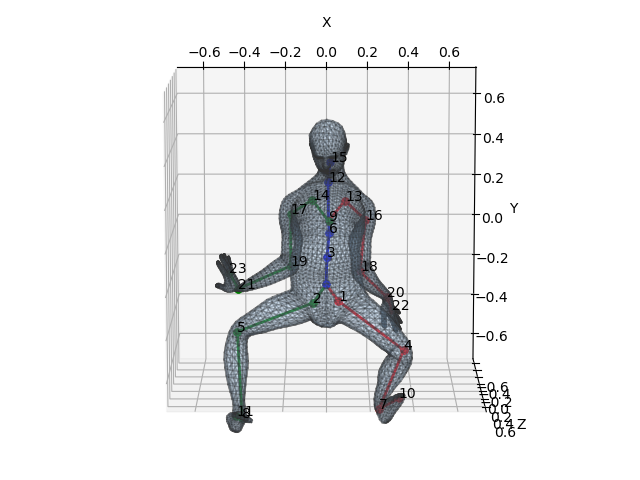

In [161]:
# cont6d_params = get6d(data)
# eye = torch.eye(3,3).view(1,1,3,3)
# cont6d_params_added_hands = rotation_6d_to_matrix(cont6d_params)[0:1]
# cont6d_params_added_hands = torch.cat([cont6d_params_added_hands,eye,eye], axis=1)
# cont6d_params_added_hands = cont6d_params_added_hands.view(1,-1)
# verts, Jtr = get_SMPL_layer(cont6d_params_added_hands)

##### 2. inverse kinematics 
##### 2.1 applied to position [without Y rotation & X-Z translation]

<IPython.core.display.Javascript object>


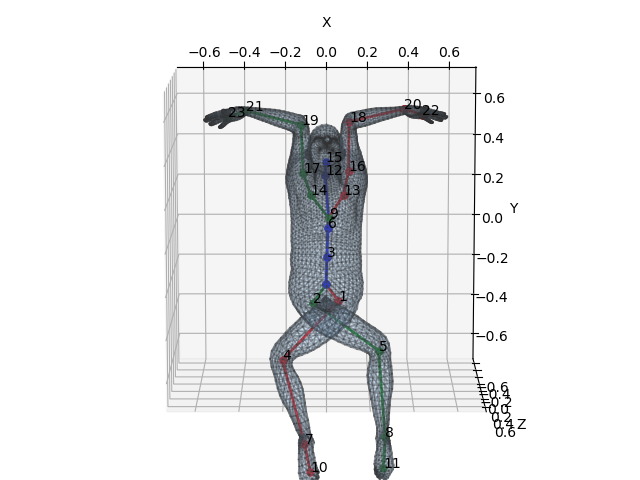

In [185]:
joints_num = 22

# positions wihtout Y rotaion & X-Z translation
r_rot_quat, r_pos = recover_root_rot_pos(data)
positions = data[..., 4:(joints_num - 1) * 3 + 4]
positions = positions.view(positions.shape[:-1] + (-1, 3))
# add root (without Y)
r_pos = r_pos.clone()
r_pos[:, [0,2]] = torch.zeros((120,2))
r_pos = r_pos.unsqueeze(-2)
positions = torch.cat([r_pos, positions], dim=-2)

# skeleton
tgt_skel = Skeleton(torch.from_numpy(paramUtil.t2m_raw_offsets), paramUtil.t2m_kinematic_chain, 'cpu')
# tgt_offsets = tgt_skel.get_offsets_joints(positions[0])
# tgt_skel.set_offset(tgt_offsets)

# inverse kinematics
face_joint_indx = [2, 1, 17, 16]
quat_params = tgt_skel.inverse_kinematics_np(positions.numpy(), face_joint_indx)
axis_angle = quaternion_to_axis_angle(torch.from_numpy(quat_params))
axis_angle = torch.cat([axis_angle,torch.zeros((120,1,3)) ,torch.zeros((120,1,3))], axis=1)

verts, Jtr = get_SMPL_layer(axis_angle[:1])

##### 2.2 applied to real joint position

<IPython.core.display.Javascript object>


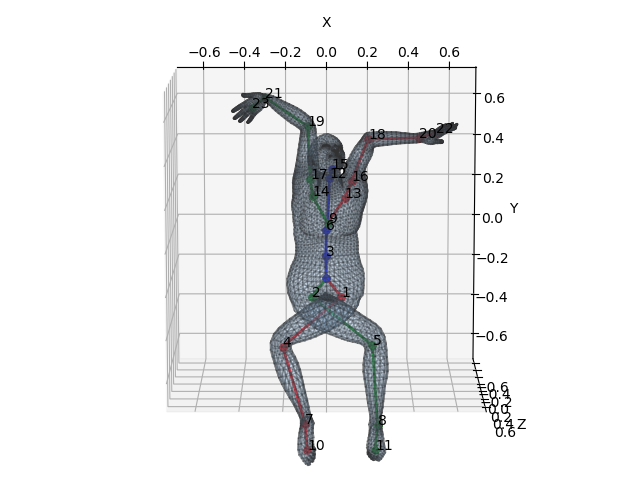

In [173]:
# Face direction, r_hip, l_hip, sdr_r, sdr_l
face_joint_indx = [2, 1, 17, 16]
quat_params = tgt_skel.inverse_kinematics_np(joint, face_joint_indx)
axis_angle = quaternion_to_axis_angle(torch.from_numpy(quat_params))
axis_angle = torch.cat([axis_angle,torch.zeros((120,1,3)),torch.zeros((120,1,3))], axis=1)
verts, Jtr = get_SMPL_layer(axis_angle[:1])

### 3. 6d -> 3x3 matrix -> axis angle

<IPython.core.display.Javascript object>


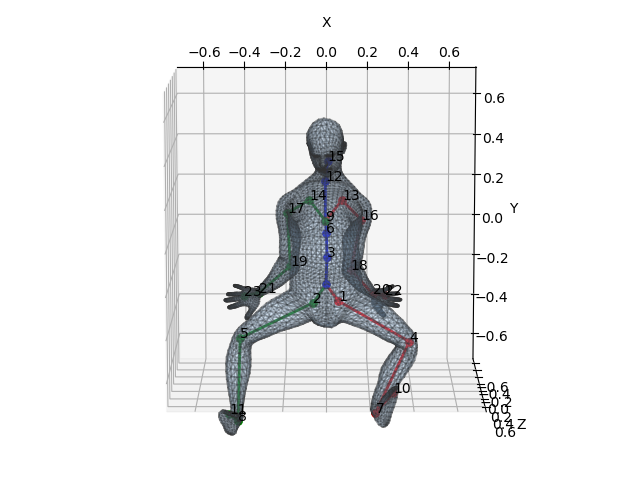

In [189]:
cont6d_params = get6d(data)
axis_angle = matrix_to_axis_angle(rotation_6d_to_matrix(cont6d_params))
axis_angle = torch.cat([axis_angle, torch.zeros((120,1,3)), torch.zeros((120,1,3))], axis=1)
verts, Jtr = get_SMPL_layer(axis_angle[:1])

### 4. From neutral pose

#### 4.1 Inverse Kinematics

<IPython.core.display.Javascript object>


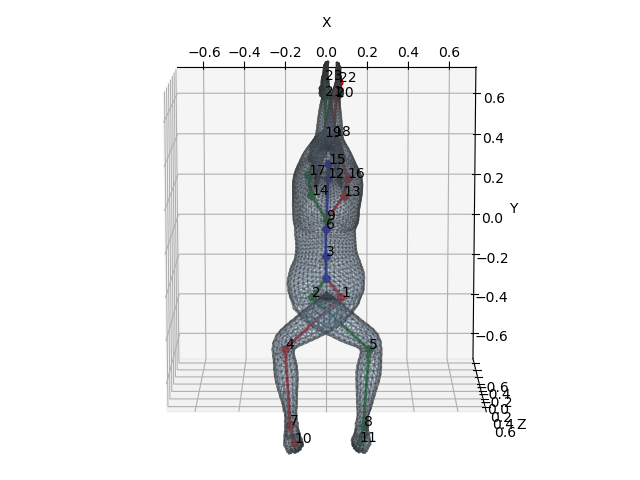

In [152]:
pose_params = torch.zeros((1, 24, 3))
verts, Jtr = get_SMPL_layer(pose_params, display=False)
tgt_skel = Skeleton(torch.from_numpy(paramUtil.t2m_raw_offsets), paramUtil.t2m_kinematic_chain, 'cpu')
# Face direction, r_hip, l_hip, sdr_r, sdr_l
face_joint_indx = [2, 1, 17, 16]
quat_params = tgt_skel.inverse_kinematics_np(Jtr.numpy(), face_joint_indx)
axis_angle = quaternion_to_axis_angle(torch.from_numpy(quat_params))
verts, Jtr = get_SMPL_layer(axis_angle)

#### 4.2 Forward Kinematics

In [199]:
pose_params = torch.zeros((1, 24, 3))
verts, Jtr = get_SMPL_layer(pose_params, display=False)
tgt_skel = Skeleton(torch.from_numpy(paramUtil.t2m_raw_offsets), paramUtil.t2m_kinematic_chain, 'cpu')
tgt_offsets = tgt_skel.get_offsets_joints(Jtr[0])
tgt_skel.set_offset(tgt_offsets)

quat_params = axis_angle_to_quaternion(pose_params)
joints = tgt_skel.forward_kinematics(quat_params, root_pos=torch.tensor([0,0,0]))
animate3d(joints.numpy())

<IPython.core.display.Javascript object>


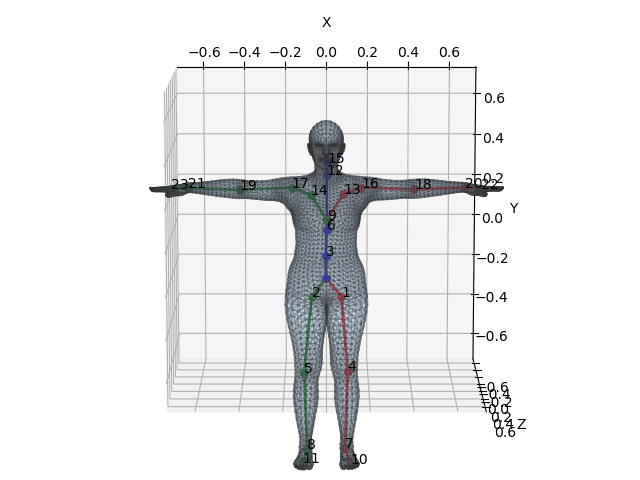

In [133]:
face_joint_indx = [2, 1, 17, 16]
quat_params = tgt_skel.inverse_kinematics_np(joints.numpy(), face_joint_indx)
axis_angle = quaternion_to_axis_angle(torch.from_numpy(quat_params))
verts, Jtr = get_SMPL_layer(axis_angle)

#### 4.2 axis_angle -> matrix 3x3 -> 6D -> matrix 3x3 -> axis_angle

<IPython.core.display.Javascript object>


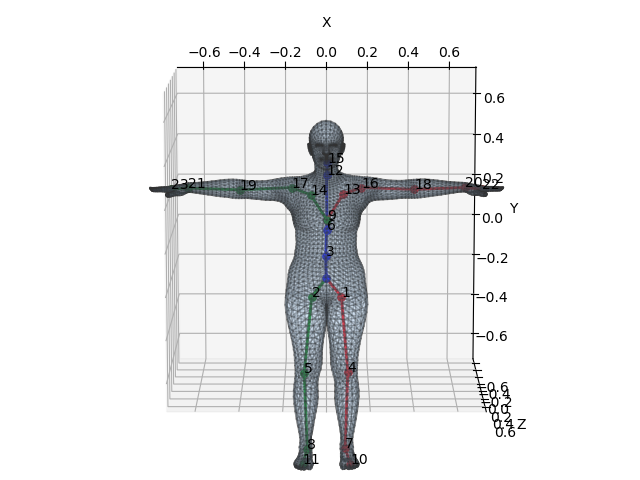

In [124]:
pose_params = torch.zeros((1, 24, 3))
# pose_params[0,17] = torch.tensor([0,1,1])
# pose_params[0,19] = torch.tensor([0,1,1])
# pose_params[0,1] = torch.tensor([0,1,1])
# pose_params[0,2] = torch.tensor([0,-1,-1])

cont6d_params = matrix_to_rotation_6d(axis_angle_to_matrix(pose_params))
pose_params = matrix_to_axis_angle(rotation_6d_to_matrix(cont6d_params))
# pose_params = axis_angle_to_quaternion(pose_params)
# pose_params = quaternion_to_axis_angle(pose_params)
verts, Jtr = get_SMPL_layer(pose_params)


### 5. Offset

In [39]:
def get_neutral_angle_offset(_kinematic_tree, joints):
    _parents = [0] * len(joints)
    _parents[0] = -1
    for chain in _kinematic_tree:
        for j in range(1, len(chain)):
            _parents[chain[j]] = chain[j-1]
            
    angle_offset = torch.zeros(joints.shape)
    for i in range(1, angle_offset.shape[0]):
        angle_offset[i] = joints[i] - joints[_parents[i]]
        angle_offset[i] = angle_offset[i]/torch.linalg.norm(angle_offset[i] , ord=2)
    return angle_offset
pose_params = torch.zeros((1,72))
verts, Jtr = get_SMPL_layer(pose_params)
angle_offset = get_neutral_angle_offset(paramUtil.t2m_kinematic_chain, Jtr[0])

<IPython.core.display.Javascript object>

In [5]:
pose_params = torch.zeros((1, 24, 3))
pose_params[:,17] = torch.tensor([1,1,1])
verts, Jtr = get_SMPL_layer(pose_params, display=False)
tgt_skel = Skeleton(angle_offset, paramUtil.t2m_kinematic_chain, 'cpu')

# offset bone size
tgt_offsets = tgt_skel.get_offsets_joints(Jtr[0])
# tgt_skel.set_offset(tgt_offsets)

quat_params = axis_angle_to_quaternion(pose_params)
joints = tgt_skel.forward_kinematics(quat_params, root_pos=torch.tensor([0,0,0]))
animate3d(joints.numpy())

In [101]:
# tgt_skel = Skeleton(angle_offset, paramUtil.t2m_kinematic_chain, 'cpu')
face_joint_indx = [2, 1, 17, 16]
quat_params = tgt_skel.inverse_kinematics_np(joints.numpy(), face_joint_indx)
axis_angle = quaternion_to_axis_angle(torch.from_numpy(quat_params))
verts, Jtr = get_SMPL_layer(axis_angle)

<IPython.core.display.Javascript object>

In [104]:
# quat_params = axis_angle_to_quaternion(axis_angle.float())
quat_params = torch.from_numpy(quat_params).float()
joints = tgt_skel.forward_kinematics(quat_params, root_pos=torch.tensor([0,0,0]))
animate3d(joints.numpy())

### Move Angle to Parent

In [40]:
verts, Jtr = get_SMPL_layer(torch.zeros((1, 24, 3)), display=False)

In [41]:
pose_params = torch.zeros((1, 24, 3))
pose_params[:,17] = torch.tensor([-1,1,1])
tgt_skel = Skeleton(angle_offset, paramUtil.t2m_kinematic_chain, 'cpu')
tgt_offsets = tgt_skel.get_offsets_joints(Jtr[0])
# tgt_skel.set_offset(tgt_offsets)

quat_params = axis_angle_to_quaternion(pose_params)
joints = tgt_skel.forward_kinematics(quat_params, root_pos=torch.tensor([0,0,0]))
animate3d(joints.numpy())

In [42]:
def move_angle_to_parent(angle_old):
    _kinematic_tree = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21,23], [9, 13, 16, 18, 20,22]]
    _parents = [0] * angle_old.shape[1]
    _parents[0] = -1
    for chain in _kinematic_tree:
        for j in range(1, len(chain)):
            _parents[chain[j]] = chain[j-1]
    angle_new = torch.zeros(angle_old.shape)
    for i in range(1, angle_new.shape[1]):
        angle_new[0,_parents[i]] = angle_old[0,i]
    return angle_new
a = move_angle_to_parent(pose_params)

<IPython.core.display.Javascript object>


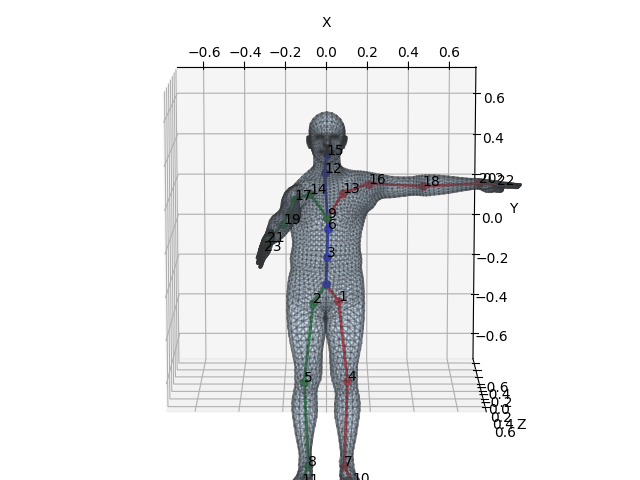

In [43]:
# quat_params = tgt_skel.inverse_kinematics_np(joints.numpy(), face_joint_idx=[2, 1, 17, 16])
# axis_angle = quaternion_to_axis_angle(torch.from_numpy(quat_params))
verts, Jtr = get_SMPL_layer(move_angle_to_parent(pose_params))

### 5. Inverse Kinematics by SMPL_layer Nuetral Offset

In [44]:
# _joint = np.concatenate((joint, torch.zeros(joint.shape[0], 2,3)), axis=1)
# joint.shape, joints.shape
_joint = joint.copy()
_joint = np.concatenate((joint, _joint[:, 20:22]), axis=1)
_joint.shape

(120, 24, 3)

In [45]:
# joint = recover_from_ric(data, joints_num=22).numpy()
animate3d(_joint)

In [46]:
tgt_skel = Skeleton(angle_offset, paramUtil.t2m_kinematic_chain, 'cpu')
vis_joint = _joint[0:1]
quat_params = tgt_skel.inverse_kinematics_np(vis_joint, face_joint_idx=[2, 1, 17, 16])
tgt_offsets = tgt_skel.get_offsets_joints(torch.from_numpy(vis_joint[0]))
joints = tgt_skel.forward_kinematics(torch.from_numpy(quat_params).float(), root_pos=torch.from_numpy(vis_joint[0,0]))
animate3d(vis_joint)
animate3d(joints.numpy())

<IPython.core.display.Javascript object>


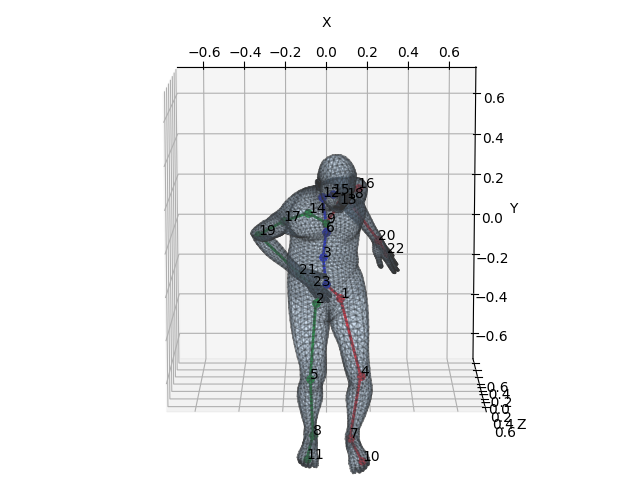

In [49]:
axis_angle = quaternion_to_axis_angle(torch.from_numpy(quat_params))
verts, Jtr = get_SMPL_layer(move_angle_to_parent(axis_angle))
animate3d(Jtr.numpy())

In [ ]:
0 seem like the first frame is working? try to FK back to joints and check position
1 IK with global
2 offset different